In [4]:
"""A notebook for running Quantum Optimal Control on the 
Unitary Coupled Cluster Single-Double ansatz for 2 qubits.
This module was adapted from 
GRAPE-Tensorflow-Examples/paper-examples/Transmon_Transmon_CNOT.ipynb
"""
import inspect, os, random as rd, sys, time, warnings

# Ignore future warnings (h5py complains) and user warnings (pylab complains).
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)

# Plot figures inline.
%pylab inline

import h5py
import numpy as np
from IPython import display
import scipy.linalg as la
from scipy.special import factorial
from quantum_optimal_control.helper_functions.grape_functions import *
from quantum_optimal_control.main_grape.grape import Grape

DATA_PATH = '../pulses/output_pulses/'

# Define time scales
TOTAL_TIME = 10.0
STEPS = 1000
QUBIT_STATE_NUM = 2

# Define H0 (drift hamiltonian)

# Helper functions
ens = lambda freq, alpha: [2*np.pi*ii*(freq - 0.5*(ii-1)*alpha) 
                               for ii in np.arange(QUBIT_STATE_NUM)]

# Frequencies in GHz, "ens" may refer to "eigens"
ALPHA_1 = 0.225
FREQ_GE_1 = 3.9
H0_1 = np.diag(ens(FREQ_GE_1, ALPHA_1))

ALPHA_2 = 0.225
FREQ_GE_2 = 3.5
H0_2 = np.diag(ens(FREQ_GE_2, ALPHA_2))

G = 2*np.pi*0.1

Q_x   = np.diag(np.sqrt(np.arange(1,QUBIT_STATE_NUM)),1)+np.diag(np.sqrt(np.arange(1,QUBIT_STATE_NUM)),-1)
Q_y   = (0+1j)*(np.diag(np.sqrt(np.arange(1,QUBIT_STATE_NUM)),1)-np.diag(np.sqrt(np.arange(1,QUBIT_STATE_NUM)),-1))
Q_z   = np.diag(np.arange(0,QUBIT_STATE_NUM))
Q_I   = np.identity(QUBIT_STATE_NUM)

# print('Q_x\n',Q_x,'\nQ_y\n',Q_y,'\nQ_z\n',Q_z,'\nQ_I\n',Q_I)

H0 = np.kron(H0_1,Q_I) + np.kron(Q_I,H0_2) + G * np.kron(Q_x,Q_x)
# For 4 qubits we expect, by symmetry:
# H0 = kron_many(H0_1, Q_I, Q_I, Q_I) + kron_many(Q_I, H0_2, Q_I, Q_I) 
#       + kron_many(Q_I, Q_I, H0_3, Q_I) + kron_many(Q_I, Q_I, Q_I, H0_4)
#       + G * np.kron(Q_x, Q_x, Q_x, Q_x)

# Define concerned states (starting states)
psi0 = [0,1,QUBIT_STATE_NUM,QUBIT_STATE_NUM+1] #[gg,ge,eg,ee]

# Define states to include in the drawing of occupation
states_draw_list = [0, 1, QUBIT_STATE_NUM, QUBIT_STATE_NUM+1]
states_draw_names = ['00','01','10','11']


# Define U (target unitary)
# 2-qubit unitary for UCCSD Ansatz
U = np.array([[5.40302306e-01+1.89554475e-17j,  2.23722740e-18+8.80012814e-18j, 
               2.23722740e-18+8.80012814e-18j, -2.23722740e-18-8.41470985e-01j],
              [2.23722740e-18+8.80012814e-18j, 5.40302306e-01+1.89554475e-17j, 
               -2.23722740e-18-8.41470985e-01j,  2.23722740e-18+8.80012814e-18j],
              [2.23722740e-18+8.80012814e-18j, -2.23722740e-18-8.41470985e-01j, 
               5.40302306e-01+1.89554475e-17j,  2.23722740e-18+8.80012814e-18j],
              [-2.23722740e-18-8.41470985e-01j,  2.23722740e-18+8.80012814e-18j, 
               2.23722740e-18+8.80012814e-18j,  5.40302306e-01+1.89554475e-17j]])
# Augment U for the number of states
#U = transmon_gate(U, QUBIT_STATE_NUM)
# print("target unitary", U, U.shape)

# Define controls
Q_x1 = np.kron(Q_x,Q_I)
Q_y1 = np.kron(Q_y,Q_I)
Q_z1 = np.kron(Q_z,Q_I)
Q_x2 = np.kron(Q_I,Q_x)
Q_y2 = np.kron(Q_I,Q_y)
Q_z2 = np.kron(Q_I,Q_z)

Hops = [Q_x1, Q_x2, Q_z2]
# ops_max_amp = [2*np.pi*0.5, 2*np.pi*0.5, 2*np.pi*0.5]
ops_max_amp = [np.pi, np.pi, np.pi]
Hnames =['x1', 'x2','z2']

# Define convergence parameters
MAX_ITERATIONS = 1000
DECAY = MAX_ITERATIONS/2
convergence = {'rate':0.01, 'update_step':10, 'max_iterations':MAX_ITERATIONS,\
               'conv_target':1e-3, 'learning_rate_decay':DECAY}

# Define reg coeffs

states_forbidden_list = []

for ii in range(QUBIT_STATE_NUM):
    forbid_state = (QUBIT_STATE_NUM-1)*QUBIT_STATE_NUM+ii
    if not forbid_state in states_forbidden_list:
        states_forbidden_list.append(forbid_state)
        
    forbid_state = (QUBIT_STATE_NUM-2)*QUBIT_STATE_NUM+ii
    if not forbid_state in states_forbidden_list:
        states_forbidden_list.append(forbid_state)
        
        
for ii in range(QUBIT_STATE_NUM):
    forbid_state = ii*QUBIT_STATE_NUM + (QUBIT_STATE_NUM-1)
    if not forbid_state in states_forbidden_list:
        states_forbidden_list.append(forbid_state)
        
    forbid_state = ii*QUBIT_STATE_NUM + (QUBIT_STATE_NUM-2)
    if not forbid_state in states_forbidden_list:
        states_forbidden_list.append(forbid_state)
        
# print ("states_forbidden_list", states_forbidden_list)

## nothing
#reg_coeffs = {'envelope' : 0.0, 'dwdt':0.0,'d2wdt2':0.0,'forbidden':0.0,
#             'states_forbidden_list': states_forbidden_list,'forbid_dressed':False}

## forbid
#reg_coeffs = {'envelope' : 0.0, 'dwdt':0.0,'d2wdt2':0.0, 'forbidden':50.0,
#              'states_forbidden_list': states_forbidden_list,'forbid_dressed':False}

## forbid + pulse reg
reg_coeffs = {'amplitude':0.01,'dwdt':0.00007,'d2wdt2':0.0, 
              'forbidden_coeff_list':[10] * len(states_forbidden_list),
              'states_forbidden_list': states_forbidden_list,'forbid_dressed':False}

Populating the interactive namespace from numpy and matplotlib
Q_x
 [[0 1]
 [1 0]] 
Q_y
 [[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]] 
Q_z
 [[ 1  0]
 [ 0 -1]] 
Q_I
 [[1. 0.]
 [0. 1.]]


data saved at: ../pulses/output_pulses/00008_uccsd_2.h5
Using 20 Taylor terms and 0 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Starting L-BFGS-B Optimization


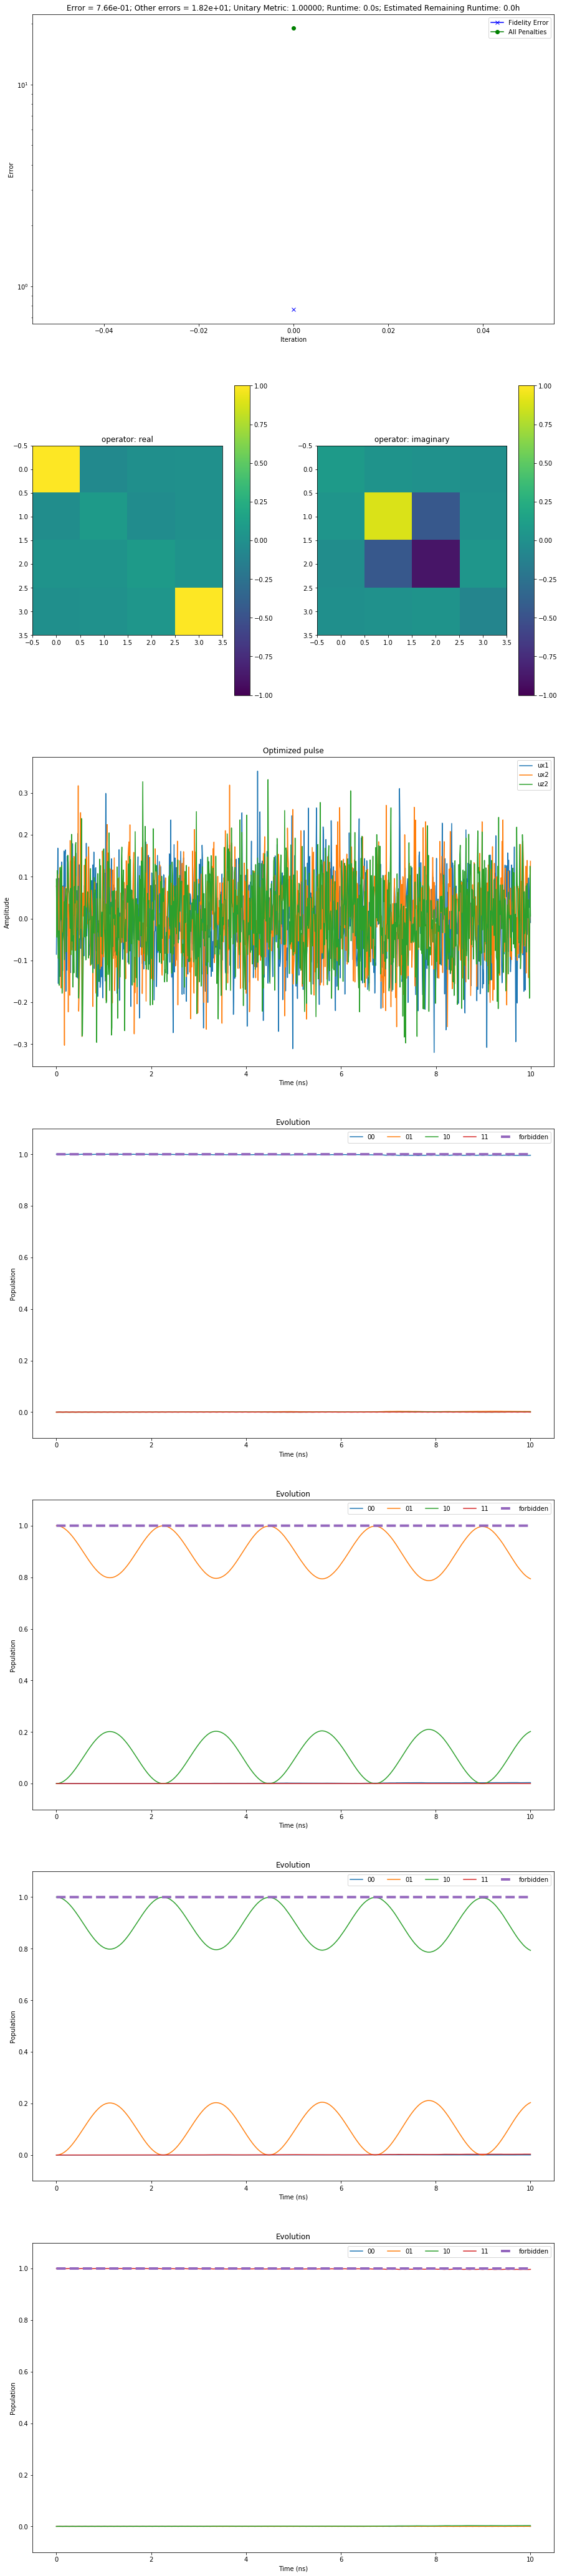

In [ ]:
# Run QOC
uks,U_f =Grape(H0, Hops, Hnames, U, TOTAL_TIME, STEPS, psi0, convergence=convergence, 
               method = 'L-BFGS-B', draw = [states_draw_list,states_draw_names] ,
               maxA = ops_max_amp, use_gpu=True, sparse_H = False, reg_coeffs=reg_coeffs, 
               unitary_error = 1e-08, show_plots = True, file_name='uccsd_2', 
               Taylor_terms = [20,0], data_path = DATA_PATH)